In [58]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path


In [59]:
file_dict = os.path.dirname(os.getcwd())
results_dir = os.path.join(file_dict, 'results')

print(str(file_dict))
print(results_dir)

d:\Nirmal\2022 FALL MIT\RA Documents\GenX\GenX_CO2\GenX\fusion_paper\paper_runs
d:\Nirmal\2022 FALL MIT\RA Documents\GenX\GenX_CO2\GenX\fusion_paper\paper_runs\results


In [139]:
# Case list
case_list = ['greenfields_fusion', 'greenfields_no_fusion', '20yr']

In [118]:
## Dictionaries to rename resources and give colors

res_name = {
    'solar_pv_2': 'Utility_Solar',
    'onshore_wind_2': 'Onshore_Wind',
    'fixed_offshore_wind_2': 'Offshore_Fixed',
    'float_offshore_wind_2': 'Offshore_Floating',
    'natural_gas_2': 'NGCC',
    'natural_gas_ccs_2': 'NGCCS',
    'battery_2': '4hr_Battery',
    'nuclear_2': 'Nuclear',
    'fusion_2': 'Fusion',
    'ror_hydro_2': 'ROR',
    'res_hydro_1': 'QC_Hydro',
    'pumped_hydro_2': 'PHS',
    'commercial_pv_2': 'Commercial_Solar',
    'residential_pv_2': 'Residential_Solar'
}

## Make a list from a start year and and end year it should be a string
years_list = [str(year) for year in range(2001, 2021)]


res_color = {
    'Utility_Solar': '#c04e01',
    'Onshore_Wind': '#033500',
    'Offshore_Fixed': '#06c2ac',
    'Offshore_Floating': '#00035b',
    'NGCC': '#6b8ba4',
    'NGCCS': '#070d0d',
    '4hr_Battery': '#B1D095',
    'Nuclear': '#fdae61',
    'Fusion': '#e50000',
    'ROR': '#4b006e',
    'QC_Hydro': '#a2cffe',
    'PHS': '#ffd1df',
    'Commercial_Solar': '#ffb07c',
    'Residential_Solar': '#0cff0c'
}


## Cost names
cost_name = {
    'cFix': 'fixed',
    'cVar': 'variable',
    'cNSE': 'NSE'
}

## Read and format inputs

In [61]:
def replace_res_name(df: pd.DataFrame, res_name: dict) -> pd.DataFrame:
    """Replace the name of the resource name in the dataframe"""
    df = df.copy()
    df['Resource'] = df['Resource'].replace(res_name)
    return df

def replace_cost_name(df: pd.DataFrame, cost_name: dict) -> pd.DataFrame:
    """Replace the name of the cost name in the dataframe"""
    df = df.copy()
    df['Costs'] = df['Costs'].replace(cost_name)
    return df

## Read in greenfield inputs

In [81]:
def load_inputs(result_dir, res_type, fus, year_list, res_name, cost_name, file_dict):
    result_dir = f"{result_dir}/{res_type}/{fus}"

    # Get the name of the resources and costs
    res_names = list(res_name.values())
    cost_names = list(cost_name.values())

    ### Initialize result files
    # Capacity
    cap_df = pd.DataFrame({'resource': res_names})

    # Costs
    cost_df = pd.DataFrame({'cost_type': cost_names})

    # Capacity Factor
    cf_df = pd.DataFrame({'resource': res_names})

    # Generation
    gen_df = pd.DataFrame({'resource': res_names})


    for year in year_list:
        result_files = f"{result_dir}/{year}"

        ####### Load Capacity #######
        df_capacity = pd.read_csv(f"{result_files}/capacity.csv")
        
        # Set any values below 0.1 to 0
        df_capacity.loc[df_capacity.EndCap <= 0.1, "EndCap"] = 0.0
        
        # Drop total in last row
        df_capacity = df_capacity.drop(df_capacity.index[-1])
        
        # Replace Resource Names
        df_capacity = replace_res_name(df_capacity, res_name)

        # Add to cap_df with mapping
        merge_caps = cap_df.merge(df_capacity[['Resource', 'EndCap']], left_on='resource', right_on='Resource', how='left')

        cap_df[year] = merge_caps['EndCap']


        ####### Load Costs #######
        df_costs = pd.read_csv(f"{result_files}/costs.csv")

        # Drop total, startup, unmet rsv and expansion
        df_costs = df_costs.iloc[1:-3]

        # Rename costs
        df_costs = replace_cost_name(df_costs, cost_name)

        # Add to cost_df with mapping
        merge_costs = cost_df.merge(df_costs[['Costs', 'Total']], left_on='cost_type', right_on='Costs', how='left')

        cost_df[year] = merge_costs['Total']


        ####### Load Capacity Factor #######
        power_df = pd.read_csv(f"{result_files}/power.csv")
        power_tot = power_df.query("Resource == 'AnnualSum'")
        power_tot = power_tot.drop(columns=['Total'])
        power_tot = power_tot.rename(columns=res_name)

        power_melt = power_tot.melt(id_vars=['Resource'], var_name='technology', value_name='power')

        merge_pwr = df_capacity.merge(power_melt[['technology', 'power']], left_on='Resource', right_on='technology', how='left')

        merge_pwr['cf'] = merge_pwr['power'] / (merge_pwr['EndCap'] * 8760)

        merge_cf = cf_df.merge(merge_pwr[['Resource', 'cf']], left_on='resource', right_on='Resource', how='left')

        cf_df[year] = merge_cf['cf']

        ######## Load Generation ########
        merge_gen = gen_df.merge(power_melt[['technology', 'power']], left_on='resource', right_on='technology', how='left')

        gen_df[year] = merge_gen['power']


    ## Write summary files to csv
    cap_df.to_csv(f"{file_dict}/visualizations/summary/capacity_{res_type}_{fus}.csv", index=False)
    cost_df.to_csv(f"{file_dict}/visualizations/summary/costs_{res_type}_{fus}.csv", index=False)
    cf_df.to_csv(f"{file_dict}/visualizations/summary/capacity_factor_{res_type}_{fus}.csv", index=False)
    gen_df.to_csv(f"{file_dict}/visualizations/summary/generation_{res_type}_{fus}.csv", index=False)

In [82]:
## Get files for greenfield fusion and no_fusion
load_inputs(results_dir, 'greenfields', 'fusion', years_list, res_name, cost_name, file_dict)
load_inputs(results_dir, 'greenfields', 'no_fusion', years_list, res_name, cost_name, file_dict)


# Read in 20 year scenario inputs

In [83]:
def load_20(result_dir, res_type, res_name, cost_name, file_dict):
    cases = ['fusion', 'no_fusion']

    result_dir = f"{result_dir}/{res_type}"

    # Get the name of the resources and costs
    res_names = list(res_name.values())
    cost_names = list(cost_name.values())

    ### Initialize result files
    # Capacity
    cap_df = pd.DataFrame({'resource': res_names})

    # Costs
    cost_df = pd.DataFrame({'cost_type': cost_names})

    # Capacity Factor
    cf_df = pd.DataFrame({'resource': res_names})

    # Generation
    gen_df = pd.DataFrame({'resource': res_names})


    for case in cases:
        result_files = f"{result_dir}/{case}"

        ####### Load Capacity #######
        df_capacity = pd.read_csv(f"{result_files}/capacity.csv")
        
        # Set any values below 0.1 to 0
        df_capacity.loc[df_capacity.EndCap <= 0.1, "EndCap"] = 0.0
        
        # Drop total in last row
        df_capacity = df_capacity.drop(df_capacity.index[-1])
        
        # Replace Resource Names
        df_capacity = replace_res_name(df_capacity, res_name)

        # Add to cap_df with mapping
        merge_caps = cap_df.merge(df_capacity[['Resource', 'EndCap']], left_on='resource', right_on='Resource', how='left')

        cap_df[case] = merge_caps['EndCap']


        ####### Load Costs #######
        df_costs = pd.read_csv(f"{result_files}/costs.csv")

        # Drop total, startup, unmet rsv and expansion
        df_costs = df_costs.iloc[1:-3]

        # Rename costs
        df_costs = replace_cost_name(df_costs, cost_name)

        # Add to cost_df with mapping
        merge_costs = cost_df.merge(df_costs[['Costs', 'Total']], left_on='cost_type', right_on='Costs', how='left')

        cost_df[case] = merge_costs['Total']


        ####### Load Capacity Factor #######
        power_df = pd.read_csv(f"{result_files}/power.csv")
        power_tot = power_df.query("Resource == 'AnnualSum'")
        power_tot = power_tot.drop(columns=['Total'])
        power_tot = power_tot.rename(columns=res_name)

        power_melt = power_tot.melt(id_vars=['Resource'], var_name='technology', value_name='power')

        merge_pwr = df_capacity.merge(power_melt[['technology', 'power']], left_on='Resource', right_on='technology', how='left')

        merge_pwr['cf'] = merge_pwr['power'] / (merge_pwr['EndCap'] * 8760)

        merge_cf = cf_df.merge(merge_pwr[['Resource', 'cf']], left_on='resource', right_on='Resource', how='left')

        cf_df[case] = merge_cf['cf']

        ######## Load Generation ########
        merge_gen = gen_df.merge(power_melt[['technology', 'power']], left_on='resource', right_on='technology', how='left')

        gen_df[case] = merge_gen['power']


    ## Write summary files to csv
    cap_df.to_csv(f"{file_dict}/visualizations/summary/capacity_{res_type}.csv", index=False)
    cost_df.to_csv(f"{file_dict}/visualizations/summary/costs_{res_type}.csv", index=False)
    cf_df.to_csv(f"{file_dict}/visualizations/summary/capacity_factor_{res_type}.csv", index=False)
    gen_df.to_csv(f"{file_dict}/visualizations/summary/generation_{res_type}.csv", index=False)
    

In [84]:
## Get 20 year info
load_20(results_dir, '20yr', res_name, cost_name, file_dict)

## Get 20 year flow data

In [170]:
cases_20yr = ['fusion', 'no_fusion']

flow = {}

for case in cases_20yr:
        df_flow = pd.read_csv(f"{results_dir}/20yr/{case}/flow.csv")
        # Drop the first row
        df_flow = df_flow.drop(df_flow.index[0])
        # Remove the Line column
        df_flow = df_flow.drop('Line', axis=1)
        # Drop the first two column s
        df_flow = df_flow.drop(df_flow.columns[:2], axis=1)
        # Set the index to be from 1 : length of df_flow
        df_flow.index = range(1, len(df_flow) + 1)

        # Rename the columns names using the line_names dictionary
        # df_flow.rename(columns={'Total': 'QC->NE'}, inplace=True)

        flow[f"{case}"] = df_flow

In [ ]:
flow_brown = {}

for year in years_list:
    df_flow = pd.read_csv(f"{results_dir}/brownfields/fus/{case}/flow.csv")
    # Drop the first row
    df_flow = df_flow.drop(df_flow.index[0])
    # Remove the Line column
    df_flow = df_flow.drop('Line', axis=1)
    # Drop the first two column s
    df_flow = df_flow.drop(df_flow.columns[:2], axis=1)
    # Set the index to be from 1 : length of df_flow
    df_flow.index = range(1, len(df_flow) + 1)

    # Rename the columns names using the line_names dictionary
    # df_flow.rename(columns={'Total': 'QC->NE'}, inplace=True)

    flow[f"{case}"] = df_flow

## NSE Extraction

In [189]:
def nse_extract(result_dir, file_dict, years_list):
    """Extracts the NSE values from the brownfields"""
    case_nse = 'no_fusion'

    load_data = pd.read_csv(f"{file_dict}/2zone_brownfields/data/no_fusion/Load_data.csv")
    load_tot = load_data['Load_MW_z2'].sum()

    result_dir = f"{result_dir}/brownfields/{case_nse}"

    #General NSE info
    nse_info = pd.DataFrame({'Statistic': ['Mean', 'Median', 'Min', 'Max']})

    # Yearly Boxplot
    nse_box = pd.DataFrame({'Greenfield_year': years_list})

    # Hours of mean load
    nse_hrs = pd.DataFrame({'Statistic': ['Hours']})

    # Duration buckets
    nse_buckets = pd.DataFrame({'Buckets': ['1-10%', '11-20%', '21-30%', '31-40%', '41-50%', '>50%']})


    for year in years_list:
        res_year = result_dir + f"/{year}"

        nse_year = pd.read_csv(f"{res_year}/nse.csv")

        nse_all = nse_year['Total'][2:]

        ### Do the yearly boxplot calcs ###
        num_segments = 20
        segments = np.array_split(nse_all, num_segments)
        summed_values_array = np.array([np.sum(segment) for segment in segments])   
        nse_box[f'{year}'] = summed_values_array

        ### Do the general NSE calcs ###
        nse_info[f'{year}'] = [np.mean(nse_all), np.median(nse_all), np.min(nse_all), np.max(nse_all)]

        ### Do the hours of mean load calcs ###
        nse_tot = nse_year['Total'][1]

        nse_mean_hours = (nse_tot / load_tot) * (8760 * 20)

        nse_hrs[f'{year}'] = nse_mean_hours

        ### Do the duration bucket calcs ###
    nse_box.to_csv(f"{file_dict}/visualizations/summary/nse_boxplots.csv", index=False)
    nse_info.to_csv(f"{file_dict}/visualizations/summary/nse_info.csv", index=False)
    nse_hrs.to_csv(f"{file_dict}/visualizations/summary/nse_hrs_mean_load.csv", index=False)

In [190]:
nse_extract(results_dir, file_dict, years_list)

## Capacity visualization

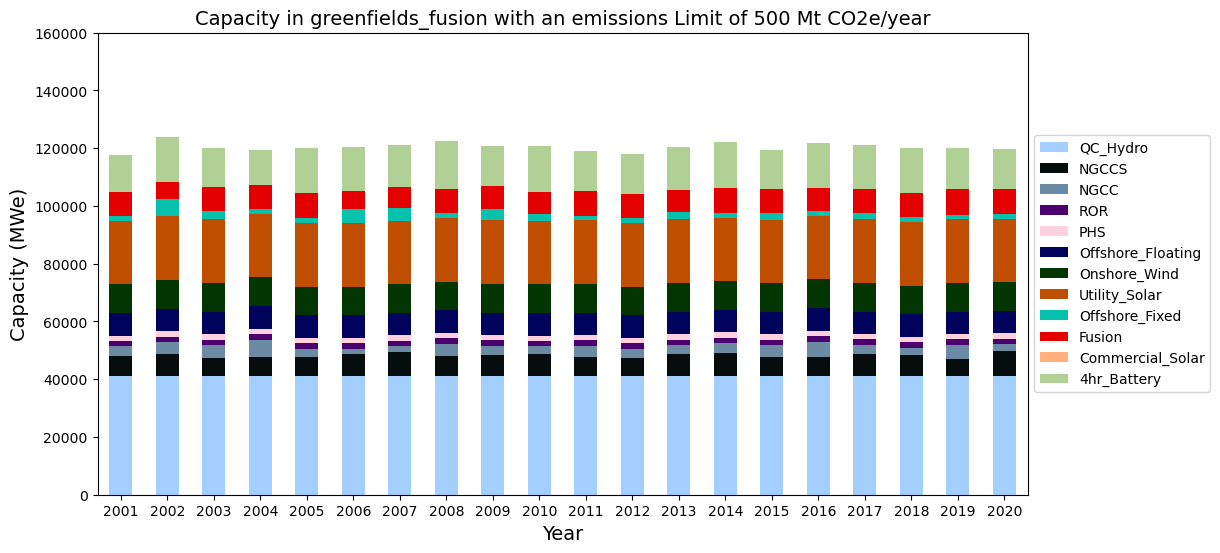

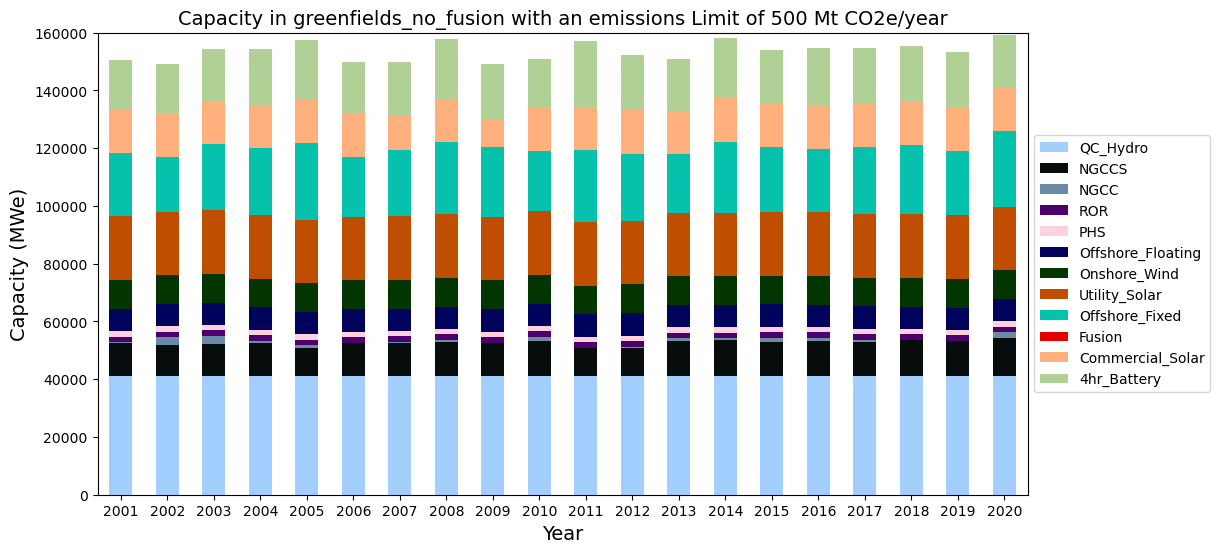

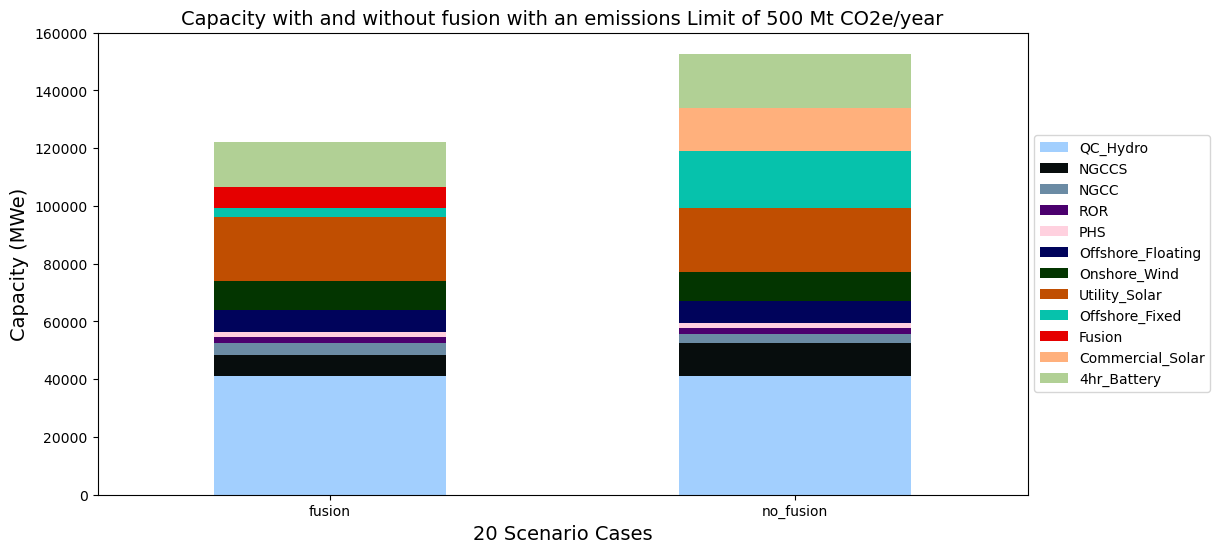

In [146]:
#### Capacity Plots (with QC) ####

for case in case_list:
    cap_case = pd.read_csv(f"{file_dict}/visualizations/summary/capacity_{case}.csv")
    
    if case == '20yr':
        cap_melt = cap_case.melt(id_vars=['resource'], var_name='case', value_name='capacity')
        cap_clean = cap_melt[cap_melt['capacity'] >= 1]
        pivot = pd.pivot_table(data=cap_clean, index=['case'], columns=['resource'], values='capacity')
    else:
        cap_melt = cap_case.melt(id_vars=['resource'], var_name='year', value_name='capacity')
        cap_clean = cap_melt[cap_melt['capacity'] >= 1]
        pivot = pd.pivot_table(data=cap_clean, index=['year'], columns=['resource'], values='capacity')

    pivot = pivot.fillna(0)

    cap_order = ["QC_Hydro", "NGCCS", "NGCC", "ROR", "PHS", "Offshore_Floating", "Onshore_Wind", "Utility_Solar", "Offshore_Fixed", "Fusion", "Commercial_Solar", "4hr_Battery"]
    pivot = pivot.reindex(columns=cap_order)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    pivot[cap_order].plot.bar(ax=ax, stacked=True, color=res_color, width=0.5)
    ax.set_ylabel('Capacity (MWe)', fontsize=14)

    if case == '20yr':
        ax.set_xlabel('20 Scenario Cases', fontsize=14)
        ax.set_title(f"Capacity with and without fusion with an emissions Limit of 500 Mt CO2e/year", fontsize=14)
    else:
        ax.set_xlabel('Year', fontsize=14)
        ax.set_title(f"Capacity in {case} with an emissions Limit of 500 Mt CO2e/year", fontsize=14)
    
    plt.xticks(rotation=0)
    ax.set_ylim([0, 160e3])
    # ax.grid(True)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=10)

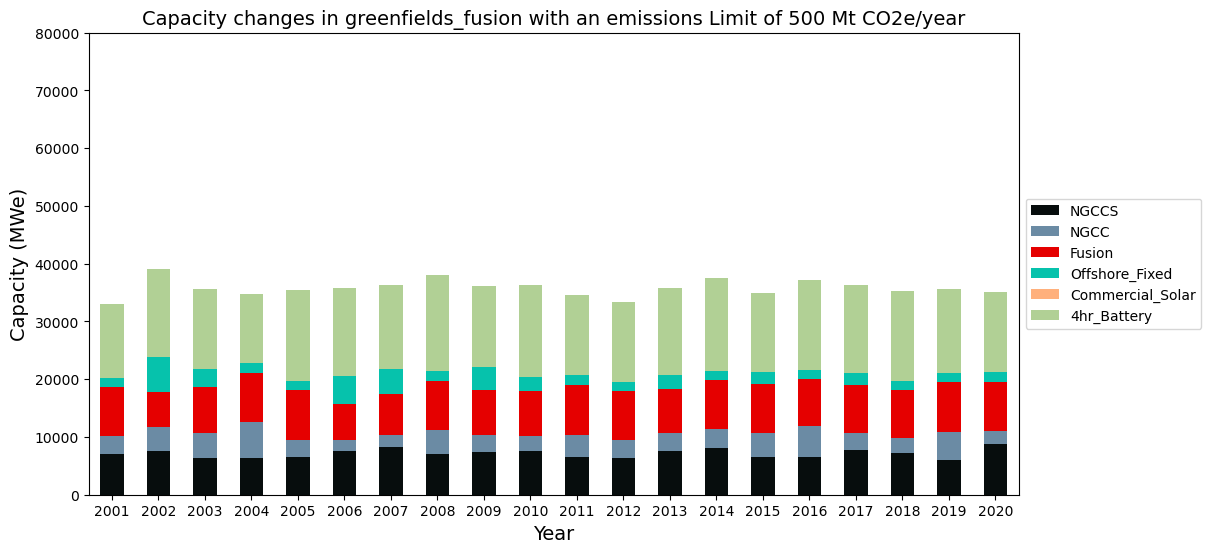

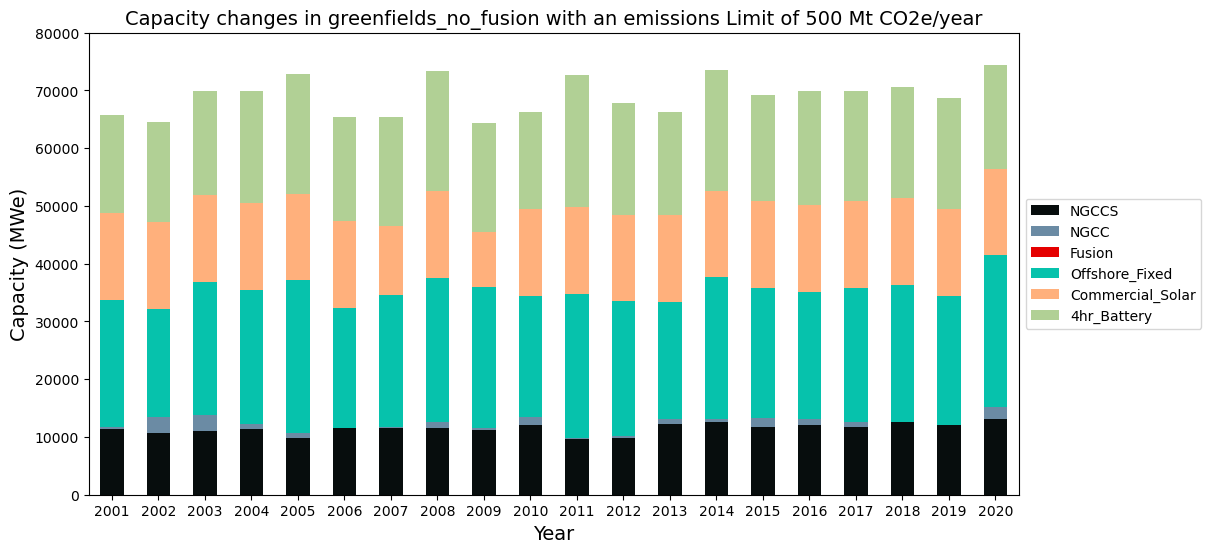

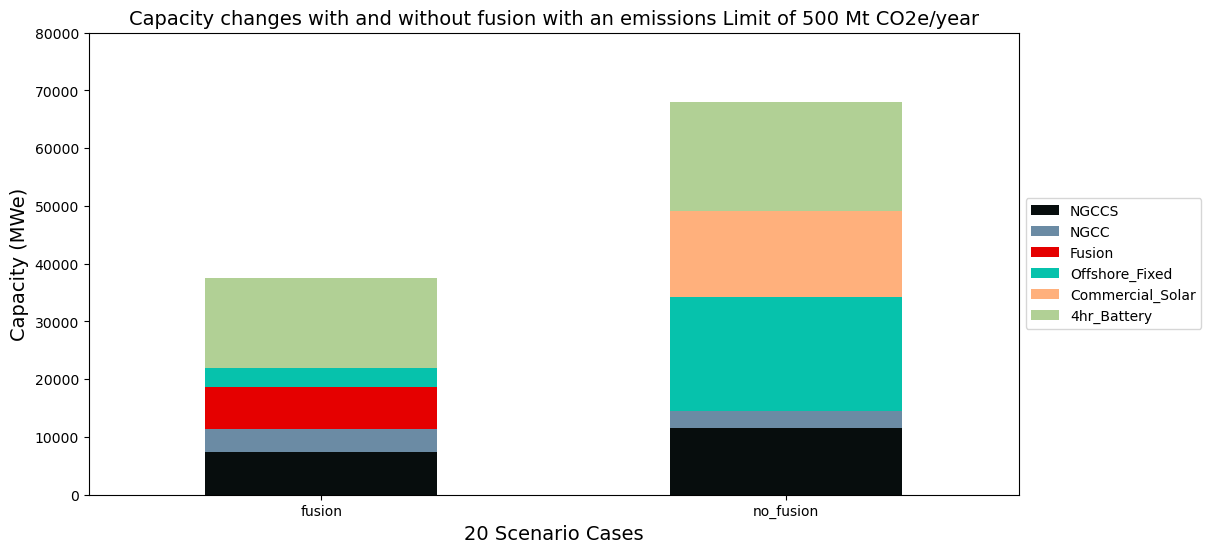

In [151]:
#### Capacity Plots (without QC) ####
for case in case_list:
    cap_case = pd.read_csv(f"{file_dict}/visualizations/summary/capacity_{case}.csv")
    
    if case == '20yr':
        cap_melt = cap_case.melt(id_vars=['resource'], var_name='case', value_name='capacity')
        cap_clean = cap_melt[cap_melt['capacity'] >= 1]
        pivot = pd.pivot_table(data=cap_clean, index=['case'], columns=['resource'], values='capacity')
    else:
        cap_melt = cap_case.melt(id_vars=['resource'], var_name='year', value_name='capacity')
        cap_clean = cap_melt[cap_melt['capacity'] >= 1]
        pivot = pd.pivot_table(data=cap_clean, index=['year'], columns=['resource'], values='capacity')

    pivot = pivot.fillna(0)
    pivot = pivot.drop(columns=['QC_Hydro', 'ROR', 'PHS', 'Offshore_Floating', 'Utility_Solar', 'Onshore_Wind'])

    cap_order_new = ["NGCCS", "NGCC", "Fusion", "Offshore_Fixed", "Commercial_Solar", "4hr_Battery"]        
    pivot = pivot.reindex(columns=cap_order)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    pivot[cap_order_new].plot.bar(ax=ax, stacked=True, color=res_color, width=0.5)
    ax.set_ylabel('Capacity (MWe)', fontsize=14)

    if case == '20yr':
        ax.set_xlabel('20 Scenario Cases', fontsize=14)
        ax.set_title(f"Capacity changes with and without fusion with an emissions Limit of 500 Mt CO2e/year", fontsize=14)
    else:
        ax.set_xlabel('Year', fontsize=14)
        ax.set_title(f"Capacity changes in {case} with an emissions Limit of 500 Mt CO2e/year", fontsize=14)
    
    plt.xticks(rotation=0)
    ax.set_ylim([0, 80e3])
    # ax.grid(True)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=10)

## Flow Visualizations

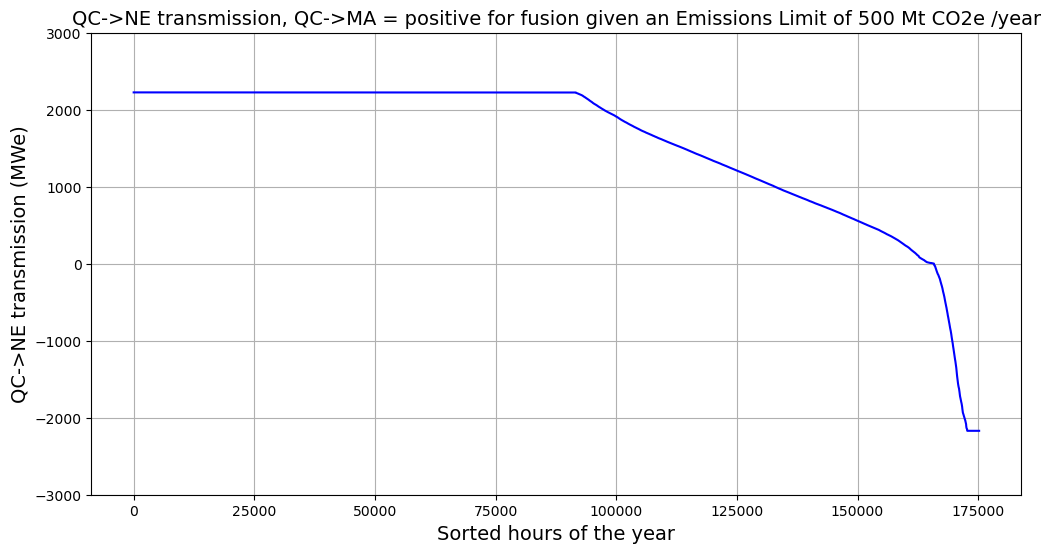

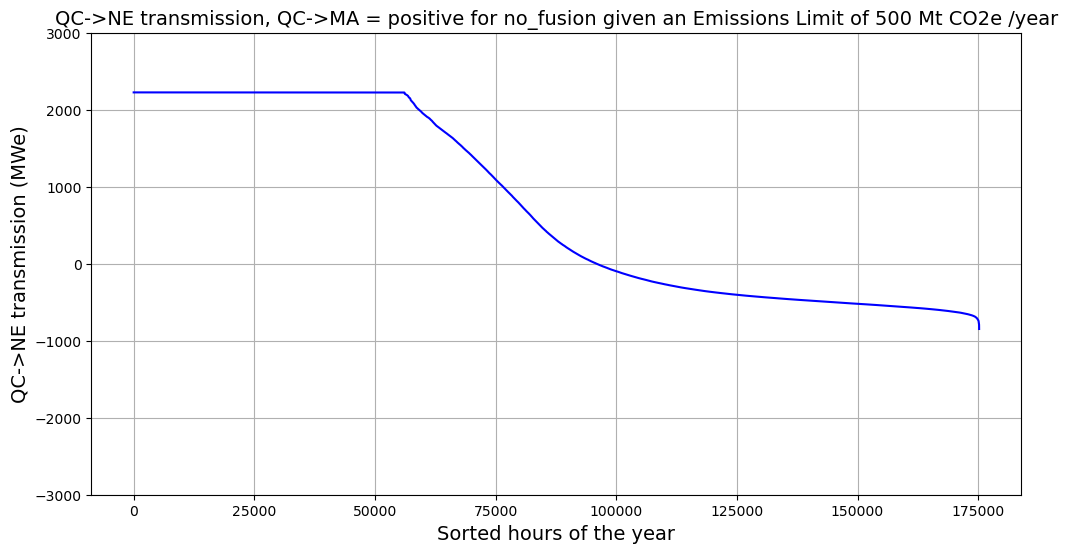

In [178]:
for case in cases_20yr:
    df_flow = flow[f"{case}"]
    sorted_qc_2_me = df_flow["Total"].sort_values(ascending=False)
    # Reset index to be from 1 : length of df_flow
    sorted_qc_2_me.index = range(1, len(sorted_qc_2_me) + 1)
    fig, ax = plt.subplots(figsize=(12, 6))
    sorted_qc_2_me.plot(ax=ax, color='blue')
    ax.set_xlabel('Sorted hours of the year', fontsize=14)
    ax.set_ylabel('QC->NE transmission (MWe)', fontsize=14)
    ax.set_title(f"QC->NE transmission, QC->MA = positive for {case} given an Emissions Limit of 500 Mt CO2e /year", fontsize=14)
    ax.set_ylim([-3e3, 3e3])
    ax.grid(True)

## Generation Visualizations

In [ ]:
gen_df = pd.read_csv(f"{file_dict}/visualizations/summary/generation_20yr.csv")


In [133]:
cap_case = pd.read_csv(f"{file_dict}/visualizations/summary/capacity_20yr.csv")

cap_melt = cap_case.melt(id_vars=['resource'], var_name='case', value_name='capacity')
cap_clean = cap_melt[cap_melt['capacity'] >= 1]
res_unique = cap_clean['resource'].unique()

pivot = pd.pivot_table(data=cap_clean, index=['case'], columns=['resource'], values='capacity')
pivot = pivot.fillna(0)
print(pivot)

resource    4hr_Battery  Commercial_Solar       Fusion         NGCC  \
case                                                                  
fusion     15668.671250          0.000000  7201.865126  3992.940429   
no_fusion  18752.416877      14999.999986     0.000000  2923.221962   

resource          NGCCS  Offshore_Fixed  Offshore_Floating  Onshore_Wind  \
case                                                                       
fusion      7374.599321     3281.785335        7748.000002  10000.000000   
no_fusion  11533.988470    19724.910111        7748.049344   9999.999839   

resource           PHS  QC_Hydro          ROR  Utility_Solar  
case                                                          
fusion     1830.200000   41108.0  1958.500000    22000.00000  
no_fusion  1830.199849   41108.0  1958.499986    21999.99984  


In [135]:
cap_order = ["QC_Hydro", "NGCCS", "NGCC", "ROR", "PHS", "Offshore_Floating", "Onshore_Wind", "Utility_Solar", "Offshore_Fixed", "Fusion", "Commercial_Solar", "4hr_Battery"]
cap_order_new = ["NGCCS", "NGCC", "Fusion", "Offshore_Fixed", "Commercial_Solar", "4hr_Battery"]

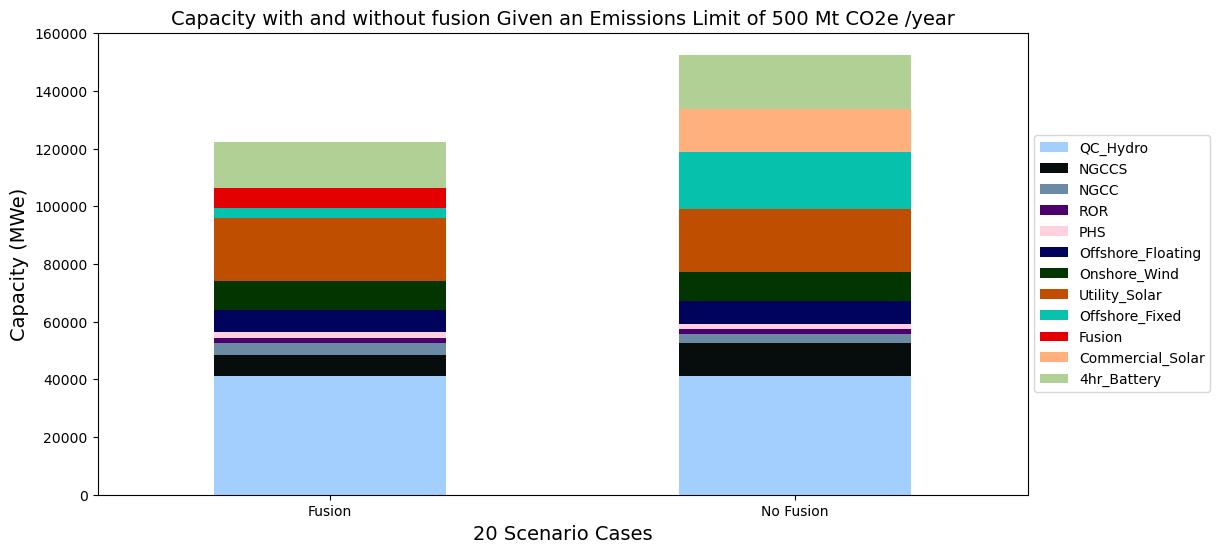

In [136]:
fig, ax = plt.subplots(figsize=(12, 6))
pivot[cap_order].plot.bar(ax=ax, stacked=True, color=res_color)
ax.set_ylabel('Capacity (MWe)', fontsize=14)
ax.set_xlabel('20 Scenario Cases', fontsize=14)
ax.set_title(f"Capacity with and without fusion Given an Emissions Limit of 500 Mt CO2e /year", fontsize=14)
ax.set_xticklabels(['Fusion','No Fusion'], rotation=0)
# ax.grid(True)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=10)

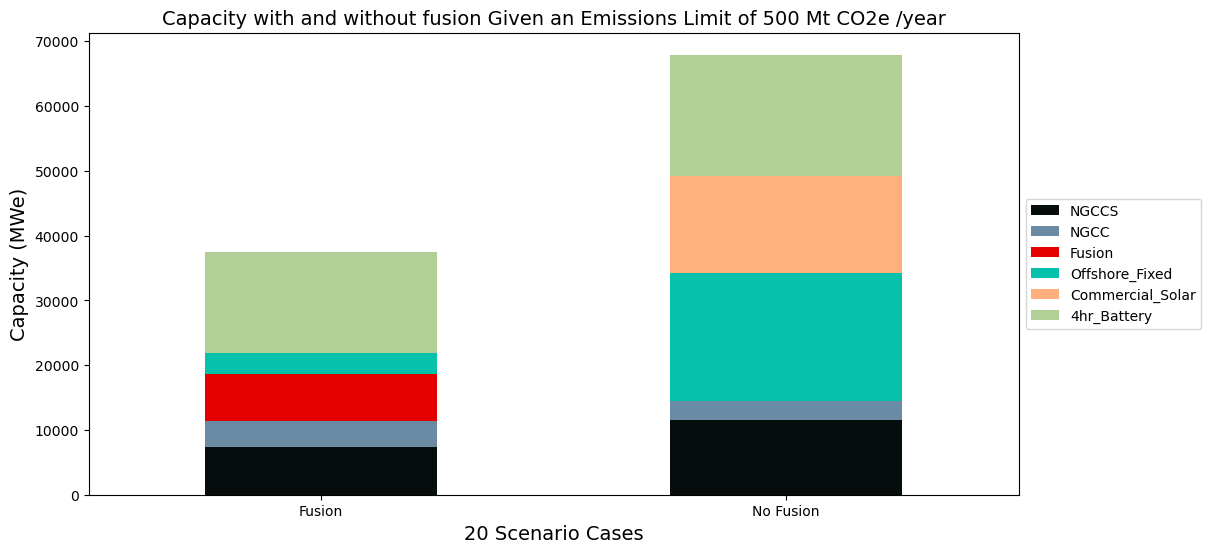

In [137]:
pivot_new = pivot.drop(columns=['QC_Hydro', 'ROR', 'PHS', 'Offshore_Floating', 'Utility_Solar', 'Onshore_Wind'])
fig, ax = plt.subplots(figsize=(12, 6))
pivot_new[cap_order_new].plot.bar(ax=ax, stacked=True, color=res_color)
ax.set_ylabel('Capacity (MWe)', fontsize=14)
ax.set_xlabel('20 Scenario Cases', fontsize=14)
ax.set_title(f"Capacity with and without fusion Given an Emissions Limit of 500 Mt CO2e /year", fontsize=14)
ax.set_xticklabels(['Fusion','No Fusion'], rotation=0)
# ax.grid(True)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=10)